# Preminary operations

Let us start by importing the relevant packages

In [1]:
import gcp
import gcp.bigquery as bq
import gcp.storage as storage
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.colors as colors
import numpy as np
import seaborn as sns

## Let us explore the dataset

In [2]:
%%sql 
SELECT * FROM [google.com:ddm-connectors-demo:aw_dataset.__TABLES__];

project_id,dataset_id,table_id,creation_time,last_modified_time,row_count,size_bytes,type
google.com:ddm-connectors-demo,aw_dataset,ACCOUNT_PERFORMANCE_DEVICE,1462865492924,1462865646222,344872,213766803,1
google.com:ddm-connectors-demo,aw_dataset,ACCOUNT_PERFORMANCE_HOUR_OF_DAY,1462866241157,1462868328687,7585976,4293195830,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_DEVICE,1462882853869,1462884926720,12818403,11156943261,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_GA,1462886351515,1462888587490,12818403,11092304675,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_HOUR_OF_DAY,1462890199029,1462910444516,149020493,120843835228,1
google.com:ddm-connectors-demo,aw_dataset,KEYWORDS_GROUPS,1464544552978,1464549920200,237127,31309185,1
google.com:ddm-connectors-demo,aw_dataset,KEYWORDS_PERFORMANCE_ANALYTICS,1462965362235,1463059120058,295426051,435427263267,1
google.com:ddm-connectors-demo,aw_dataset,KEYWORDS_PERFORMANCE_DEVICE,1463050362280,1463408383328,447387461,631380449113,1


## Lest us explore the table KEYWORDS_PERFORMANCE_ANALYTICS

In [3]:
%bigquery schema --table google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS

## Let us see how the data look like

In [4]:
%bigquery sample --table google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS --count 5

AccountCurrencyCode,AccountDescriptiveName,AccountTimeZoneId,ActiveViewCpm,ActiveViewCtr,ActiveViewImpressions,ActiveViewMeasurability,ActiveViewMeasurableCost,ActiveViewMeasurableImpressions,ActiveViewViewability,AdGroupId,AdGroupName,AdGroupStatus,AdNetworkType1,AdNetworkType2,AllConversionRate,AllConversions,AllConversionValue,ApprovalStatus,AverageCost,AverageCpc,AverageCpe,AverageCpm,AverageCpv,AveragePageviews,AveragePosition,AverageTimeOnSite,BaseAdGroupId,BaseCampaignId,BiddingStrategyId,BiddingStrategyName,BiddingStrategySource,BiddingStrategyType,BidType,BounceRate,CampaignId,CampaignName,CampaignStatus,ClickAssistedConversionsOverLastClickConversions,ClickAssistedConversionValue,ClickConversionRate,Clicks,ConversionRate,Conversions,ConversionValue,ConvertedClicks,Cost,CostPerAllConversion,CostPerConversion,CostPerConvertedClick,CpcBid,CpcBidSource,CpmBid,CreativeQualityScore,Criteria,CriteriaDestinationUrl,CrossDeviceConversions,Ctr,CustomerDescriptiveName,Date,DayOfWeek,EngagementRate,Engagements,EnhancedCpcEnabled,EstimatedAddClicksAtFirstPositionCpc,EstimatedAddCostAtFirstPositionCpc,ExternalCustomerId,FinalAppUrls,FinalMobileUrls,FinalUrls,FirstPageCpc,FirstPositionCpc,GmailForwards,GmailSaves,GmailSecondaryClicks,Id,ImpressionAssistedConversions,ImpressionAssistedConversionsOverLastClickConversions,ImpressionAssistedConversionValue,Impressions,InteractionRate,Interactions,IsNegative,KeywordMatchType,LabelIds,Labels,Month,MonthOfYear,PercentNewVisitors,PostClickQualityScore,PrimaryCompanyName,QualityScore,Quarter,SearchExactMatchImpressionShare,SearchImpressionShare,SearchPredictedCtr,SearchRankLostImpressionShare,Status,SystemServingStatus,TopOfPageCpc,TrackingUrlTemplate,UrlCustomParameters,ValuePerAllConversion,ValuePerConversion,ValuePerConvertedClick,VideoQuartile100Rate,VideoQuartile25Rate,VideoQuartile50Rate,VideoQuartile75Rate,VideoViewRate,VideoViews,ViewThroughConversions,Week,Year
EUR,Bravofly FR,(GMT+01:00) Paris,20000000,11.11%,9,100.00%,180000,11,81.82%,4742873125,Bravofly Misspellings,enabled,Display Network,Display Network,0.00%,0.0,0.0,--,180000,180000,0,16363636,0,1.0,1.0,0,4742873125,98913565,0,--,campaign,cpc,--,100.00%,98913565,Brand Content,enabled,0.0,0.0,0.00%,1,0.00%,0.0,0.0,0,180000,0,0,0,--,--,--,Not applicable,Content,--,0.0,9.09%,Bravofly FR,2015-09-30,Wednesday,0.00%,0,False,--,--,9348411392,--,--,--,0,0,0,0,0,3000000,0,0.0,0.0,11,9.09%,1,False,Broad,--,--,2015-09-01,September,100.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-07-01,--,--,Not applicable,--,enabled,eligible,0,--,--,0.0,0.0,0.0,0.00%,0.00%,0.00%,0.00%,0.00%,0,0,2015-09-28,2015
EUR,Bravofly Russia Voli,(GMT+01:00) Rome,0,0.00%,0,0.00%,0,0,0.00%,3639849698,Bravoavia,enabled,Search Network,Google search,0.00%,0.0,0.0,--,140000,140000,0,17500000,0,7.0,4.8,139,3639849698,108030218,0,--,campaign,cpc,--,0.00%,108030218,Brand_RU_Broad,enabled,0.0,0.0,0.00%,1,0.00%,0.0,0.0,0,140000,0,0,0,--,--,--,Not applicable,бравоавиа билеты,--,0.0,12.50%,Bravofly Russia Voli,2015-03-22,Sunday,0.00%,0,False,--,--,9837210897,--,--,--,0,0,0,0,0,33239627618,0,0.0,0.0,8,12.50%,1,False,Broad,--,--,2015-03-01,March,0.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-01-01,--,57.14%,Not applicable,42.86%,removed,--,0,--,--,0.0,0.0,0.0,0.00%,0.00%,0.00%,0.00%,0.00%,0,0,2015-03-16,2015
EUR,Bravofly Russia Voli,(GMT+01:00) Rome,0,0.00%,0,0.00%,0,0,0.00%,3639850178,Bravofly,enabled,Search Network,Search partners,0.00%,0.0,0.0,--,0,0,0,0,0,0.0,1.0,0,3639850178,108030218,0,--,campaign,cpc,--,0.00%,108030218,Brand_RU_Broad,enabled,0.0,0.0,0.00%,0,0.00%,0.0,0.0,0,0,0,0,0,--,--,--,Not applicable,bravofly,--,0.0,0.00%,Bravofly Russia Voli,2015-03-19,Thursday,0.00%,0,False,--,--,9837210897,--,--,--,0,0,0,0,0,3117710189,0,0.0,0.0,1,0.00%,0,False,Phrase,--,--,2015-03-01,March,0.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-01-01,--,100.00%,Not applicable,0.00%,remo

# Let us start checking the monthly performance on Volagratis in Italy

In [5]:
%sql --module monthly_keywords_performance
SELECT
  AccountDescriptiveName,
  CampaignName,
  AdGroupName,
  Criteria,
  KeywordMatchType,
  COUNT(Month) as MonthsWithImpressions,
  AVG(Impressions) as Impressions,
  AVG(ImpressionAssistedConversions) as ImpressionAssistedConversions,
  AVG(Clicks) as Clicks,
  AVG(ClickAssistedConversions) as ClickAssistedConversions,  
  AVG(CTR) as CTR,
  AVG(CostEUR/Clicks) as CPC,
  AVG(QualityScore) as QualityScore, 
  AVG(CostEUR) as CostEUR,
  AVG(AllConversions) as AllConversions,
  AVG(Conversions) as Conversions,    
  AVG(CostPerAllConversion) as CostPerAllConversion,
  AVG(CostPerConversion) as CostPerConversion,  
  #Analytics Metrics
  AVG(BounceRate) as BounceRate,
  AVG(AveragePosition) as AveragePosition,
  AVG(AveragePageviews) as AveragePageviews,
  AVG(AverageTimeOnSite) as AverageTimeOnSite,
  AVG(PercentNewVisitors) as PercentNewVisitors,
FROM
(
SELECT
  Month,
  AccountDescriptiveName,
  CampaignName,
  AdGroupName,
  Criteria,
  KeywordMatchType,
  SUM(Impressions) as Impressions,
  SUM(ImpressionAssistedConversions) as ImpressionAssistedConversions,
  SUM(Clicks) as Clicks,
  SUM(Clicks)/SUM(Impressions) as CTR,
  SUM(IF(ClickAssistedConversionsOverLastClickConversions = 0, 0,
  CASE
    WHEN Conversions > 0 OR AllConversions > 0 THEN IF(AllConversions>Conversions,AllConversions,Conversions)*ClickAssistedConversionsOverLastClickConversions
    WHEN ImpressionAssistedConversions > 0 THEN ImpressionAssistedConversions*ClickAssistedConversionsOverLastClickConversions
    ELSE 1.0
  END
  )) as ClickAssistedConversions,
  
  AVG(QualityScore) as QualityScore,
  
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000 as CostEUR,
  SUM(AllConversions) as AllConversions,
  SUM(Conversions) as Conversions,  
  
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000/SUM(AllConversions) as CostPerAllConversion,
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000/SUM(Conversions) as CostPerConversion,
  
  #Analytics Metrics
  SUM(FLOAT(RTRIM(BounceRate,'%'))/100.0 * Clicks)/SUM(Clicks) as BounceRate,
  SUM(AveragePosition * Impressions)/SUM(Impressions) as AveragePosition,
  SUM(AveragePageviews * Clicks)/SUM(Clicks) as AveragePageviews,
  SUM(AverageTimeOnSite * Clicks)/SUM(Clicks) as AverageTimeOnSite,
  SUM(FLOAT(RTRIM(PercentNewVisitors,'%'))/100.0 * Clicks)/SUM(Clicks) as PercentNewVisitors,

FROM
  [google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS]
WHERE TRUE
AND NOT IsNegative
AND AdNetworkType2 = 'Google search'
AND Impressions > 0 
AND Month IN ('2015-08-01','2015-09-01','2015-10-01','2015-11-01')
AND AccountDescriptiveName IN ('Account Primario Volagratis','Volagratis Tratte Italia','Volagratis')
GROUP BY 1,2,3,4,5,6)
GROUP BY 1,2,3,4,5

In [6]:
df = bq.Query(monthly_keywords_performance).to_dataframe()

## Does it make sense to differentiate among Brand and Generic?

Let us identify the Brand Keywords by assuming that 
- they have at least 10 impressions a month
- their CTR is higher the "normal"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84ce1de150>]], dtype=object)

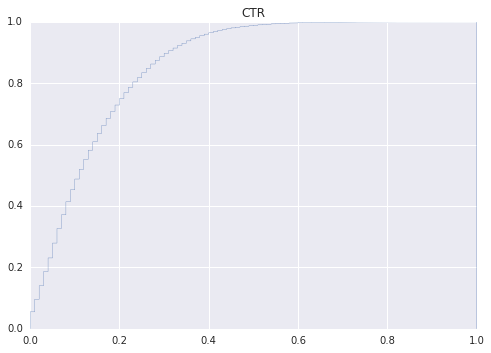

In [8]:
df[df['Impressions']>10].hist('CTR',bins=np.arange(101)/100.0,
                              normed=True,cumulative=1,histtype='step')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84d92b0b50>]], dtype=object)

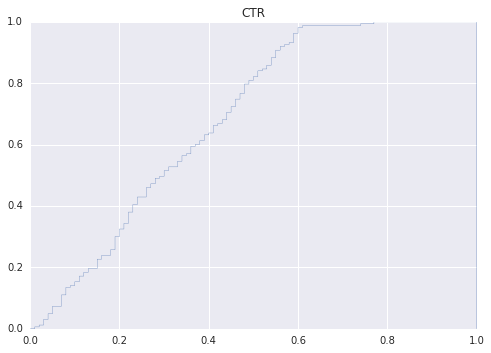

In [9]:
df[(df['AdGroupName'] == 'Brand')&(df['Impressions']>10)].hist('CTR',bins=np.arange(101)/100.0,
                                                              cumulative=1,normed=1,
                                                               histtype='step')

In [10]:
df[(df['AdGroupName'] == 'Brand')&
   (df['CTR']<0.4)&
   (df['Impressions']>10)].sort_values(by='CostEUR',ascending=False)[['AccountDescriptiveName',
                                                                                        'CampaignName',
                                                                                        'AdGroupName',
                                                                                        'Criteria',
                                                                                        'KeywordMatchType',
                                                                                        'CTR',
                                                                                        'Impressions',
                                                                                        'CostEUR']]

,AccountDescriptiveName,CampaignName,AdGroupName,Criteria,KeywordMatchType,CTR,Impressions,CostEUR
158324,Account Primario Volagratis,Volagratis Brand 2008,Brand,volagratis,Broad,0.394789,63899.000000,1797.932500
144920,Account Primario Volagratis,Volagratis Brand 2008,Brand,volare+quasi+gratis,Broad,0.150072,11110.000000,791.025000
110833,Account Primario Volagratis,Volagratis Brand 2008,Brand,volaregratis,Broad,0.151932,8289.250000,507.210000
173878,Account Primario Volagratis,Volagratis Brand 2008,Brand,+vola +gratis,Broad,0.263844,5103.500000,366.902500
186229,Account Primario Volagratis,Volagratis Brand 2008,Brand,volarequasigratis,Broad,0.108528,5629.500000,256.187500
147183,Account Primario Volagratis,Volagratis Brand 2008,Brand,voli gratis,Broad,0.195364,4235.000000,227.090000
110944,Account Primario Volagratis,Volagratis Brand 2008,Brand,+voli +gratis,Broad,0.166203,1748.750000,186.925000
184670,Account Primario Volagratis,Volagratis Brand 2008,Brand,volare+gratis,Broad,0.181677,3170.000000,102.030000
195398,Account Primario Volagratis,Volagratis Brand 2008,Brand,+volagratis. +com,Broad,0.363307,1722.500000,101.712500
115142,Account Primario Volagratis,Volagratis Brand 2008,Brand,viaggiaregratis,Broad,0.118842,2314.000000,76.560000


In [11]:
df[(df['Impressions']>10) & (df['CTR']>0.4)].sort_values(by='CostEUR',ascending=False)[['AccountDescriptiveName',
                                                                                        'CampaignName',
                                                                                        'AdGroupName',
                                                                                        'Criteria',
                                                                                        'KeywordMatchType',
                                                                                        'CTR',
                                                                                        'Impressions',
                                                                                        'CostEUR']]

,AccountDescriptiveName,CampaignName,AdGroupName,Criteria,KeywordMatchType,CTR,Impressions,CostEUR
162465,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volagratis,Exact,0.470241,768536.750000,19108.502500
217261,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,vola+gratis,Exact,0.481492,36716.750000,1672.845000
4915,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Missp,voli gratis,Exact,0.527447,7832.000000,940.015000
29943,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volaregratis,Exact,0.460768,14547.000000,534.662500
42949,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volare+gratis,Exact,0.484875,10885.000000,483.537500
107762,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,vola quasi gratis,Exact,0.410945,2990.500000,451.790000
3675,Account Primario Volagratis,Volagratis Brand 2008,Voli Brand,+volagratis +volo,Broad,0.423306,3084.750000,369.657500
11486,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Missp,vologratis,Exact,0.576304,7332.500000,355.037500
39579,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volo gratis,Exact,0.499794,2869.500000,301.420000
93038,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volagratis offerte,Exact,0.610439,3945.000000,236.472500


In [12]:
df['KeywordType'] = df.apply(lambda x: 'Gold' if 
                             (x['Impressions']>10 and x['CTR']>0.4) 
                             else 'Standard', axis=1)


## Let us start assessing the performance of the converting keywords

In [13]:
df.groupby(by=(df['AllConversions'] > 0))[['AllConversions','ClickAssistedConversions',
                                           'ImpressionAssistedConversions','CostEUR',
                                           'Impressions','Clicks',
                                           'Criteria']].aggregate({'AllConversions':sum,
                                                                   'ClickAssistedConversions':sum,
                                                                   'ImpressionAssistedConversions':sum,
                                                                   'CostEUR':sum,
                                                                   'Impressions':sum,
                                                                   'Clicks':sum,
                                                                   'Criteria':'count'})

,ClickAssistedConversions,CostEUR,ImpressionAssistedConversions,AllConversions,Criteria,Impressions,Clicks
AllConversions,,,,,,,
False,1.750,144337.040833,4754.750000,0.000000,229112,3.541092e+06,416103.333333
True,12149.375,269389.197500,17589.833333,23429.583333,8015,5.345909e+06,960292.416667


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84bf933ad0>]], dtype=object)

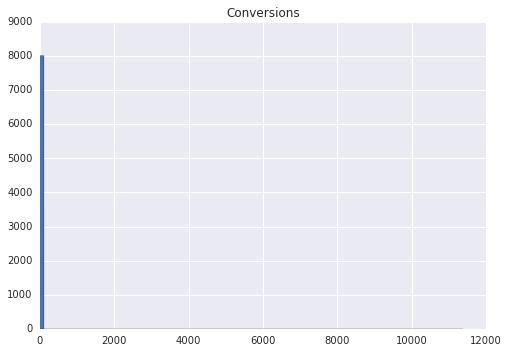

In [14]:
df[df['AllConversions'] > 0].hist('Conversions',bins=100)

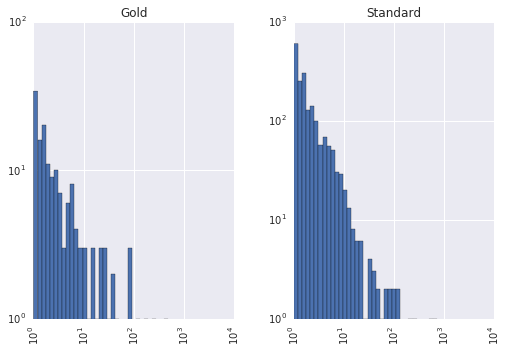

In [15]:
axes = df[df['AllConversions'] > 0].hist('AllConversions',bins=np.logspace(0,4),log=True,by='KeywordType')
axes[0].set_xscale('log')
axes[1].set_xscale('log')

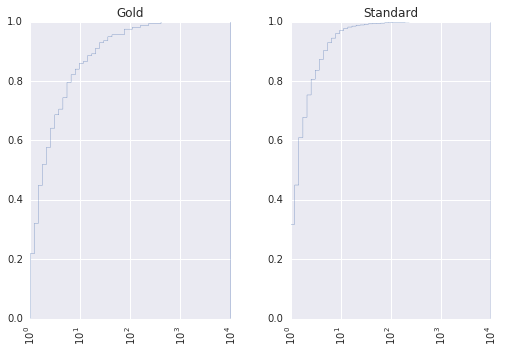

In [16]:
axes = df[df['AllConversions'] > 0].hist('AllConversions',bins=np.logspace(0,4),by='KeywordType',
              cumulative=1,normed=True,histtype='step')
axes[0].set_xscale('log')
axes[1].set_xscale('log')

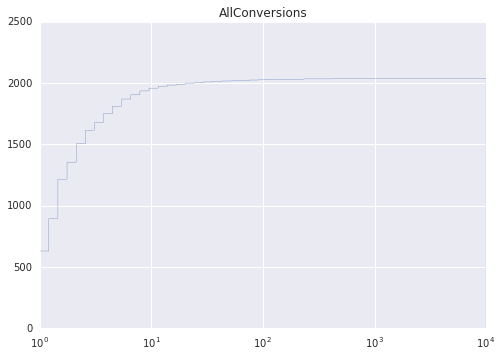

In [17]:
df[df['AllConversions'] > 0].hist('AllConversions',bins=np.logspace(0,4),
              cumulative=1,histtype='step')
plt.gca().set_xscale('log')

In [18]:
def setGroup(x):
  if x['AllConversions'] > 0:
    return 'Converter'
  else:
    return 'Other'
  
def setSubGroup(x):
  if x['AllConversions'] > 99:
    return 'Converter - High'
  elif x['AllConversions'] > 9:
    return 'Converter - Mid'
  elif x['AllConversions'] > 2:
    return 'Converter - Low'
  elif x['AllConversions'] > 0:
    return 'Converter - Occasional'
  else:
    return 'Other'
  
df['Group'] = df.apply(setGroup,axis=1)
df['SubGroup'] = df.apply(setSubGroup,axis=1)

In [19]:
df.groupby(by='SubGroup')[['AllConversions','ClickAssistedConversions',
                                           'ImpressionAssistedConversions','CostEUR',
                                           'Impressions','Clicks',
                                           'Criteria']].aggregate({'AllConversions':sum,
                                                                   'ClickAssistedConversions':sum,
                                                                   'ImpressionAssistedConversions':sum,
                                                                   'CostEUR':sum,
                                                                   'Impressions':sum,
                                                                   'Clicks':sum,
                                                                   'Criteria':'count'})

,ClickAssistedConversions,CostEUR,ImpressionAssistedConversions,AllConversions,Criteria,Impressions,Clicks
SubGroup,,,,,,,
Converter - High,9610.800000,90426.690000,7556.500000,14945.250000,13,1.893781e+06,522184.000000
Converter - Low,612.225000,54546.787500,2950.833333,2261.250000,573,9.023092e+05,122551.500000
Converter - Mid,1243.808333,58189.660000,3265.250000,2186.750000,96,1.077762e+06,123119.666667
Converter - Occasional,682.541667,66226.060000,3817.250000,4036.333333,7333,1.472056e+06,192437.250000
Other,1.750000,144337.040833,4754.750000,0.000000,229112,3.541092e+06,416103.333333


## Let as check how the attributes of the Converters looks like 

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


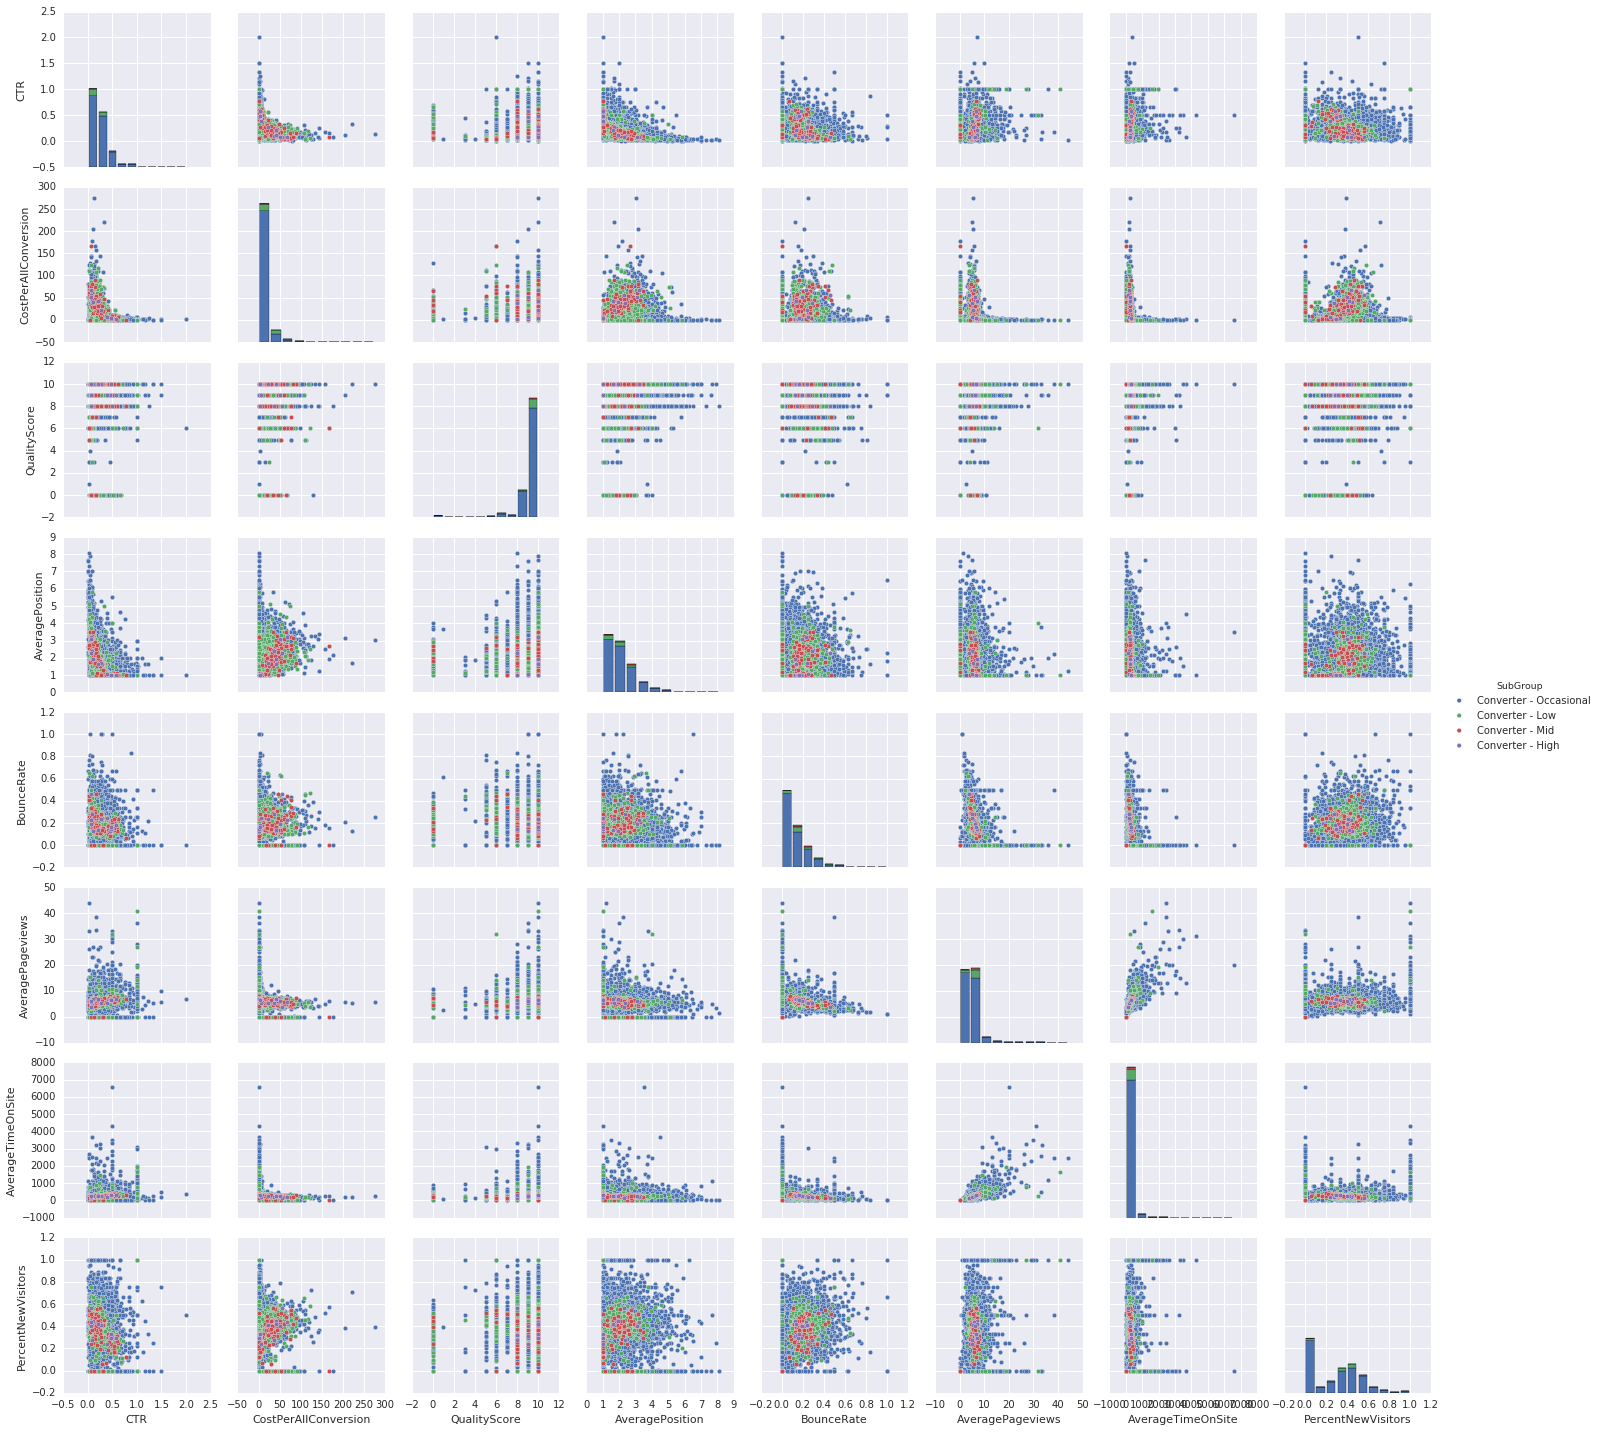

In [20]:
g = sns.pairplot(data=df[df['Group'] == 'Converter'][[u'SubGroup','CTR',
                                                  'CostPerAllConversion',
                            u'QualityScore',u'AveragePosition',                          
                            u'BounceRate', u'AveragePageviews',
                            u'AverageTimeOnSite',u'PercentNewVisitors']],hue=u'SubGroup')

In [ ]:
g = sns.pairplot(data=df[df['Group'] == 'Converter'][[u'SubGroup',                         
                            u'BounceRate', u'AveragePageviews',
                            u'AverageTimeOnSite',u'PercentNewVisitors']],hue=u'SubGroup')

In [ ]:
g = sns.pairplot(data=df[df['Group'] == 'Converter'][[u'SubGroup','CTR',
                                                  'CostPerAllConversion',
                            u'QualityScore',u'AveragePosition',                          
                            u'BounceRate',u'PercentNewVisitors']],hue=u'SubGroup')

## Can we move away from LastClick?

In [ ]:
df.groupby(by='SubGroup')[['AllConversions','ClickAssistedConversions',
                        'ImpressionAssistedConversions',
                        'CostEUR','Impressions','Clicks',
                        'Criteria']].aggregate({'AllConversions':sum,
                                                'ClickAssistedConversions':sum,
                                                'ImpressionAssistedConversions':sum,
                                                'CostEUR':sum,
                                                'Impressions':sum,
                                                'Clicks':sum,
                                                'Criteria':'count'})

In [ ]:
df[df['Group'] == 'Other'].groupby(by=(df[df['Group'] == 'Other']['ClickAssistedConversions'] +
                                       df[df['Group'] == 'Other']['ImpressionAssistedConversions']>0))[
  ['ClickAssistedConversions','ImpressionAssistedConversions','CostEUR',
   'Impressions','Clicks','Criteria']].aggregate({'ClickAssistedConversions':sum,
                                                  'ImpressionAssistedConversions':sum,
                                                  'CostEUR':sum,
                                                  'Impressions':sum,
                                                  'Clicks':sum,
                                                  'Criteria':'count'})

In [ ]:
def setGroup(x):
  if x['AllConversions'] > 0:
    return 'Converter'
  elif x['Clicks'] > 0:
    return 'Click'
  else:
    return 'Impressions'
  
def setSubGroup(x):
  if x['AllConversions'] > 99:
    return 'Converter - High'
  elif x['AllConversions'] > 9:
    return 'Converter - Mid'
  elif x['AllConversions'] > 2:
    return 'Converter - Low'
  elif x['AllConversions'] > 0:
    return 'Converter - Occasional'
  elif x['Clicks'] > 0:
    return 'Click'
  else:
    return 'Impressions'
  
df['Group'] = df.apply(setGroup,axis=1)
df['SubGroup'] = df.apply(setSubGroup,axis=1)

In [ ]:
df.hist('CPC',by='SubGroup',bins=100)

In [ ]:
with sns.axes_style({ 'axes.facecolor': 'white','axes.grid': False}):
  fig,ax = plt.subplots()
  data=df[df['Group'] == 'Click'].plot(x='CostEUR',y='CPC', 
                                     kind='hexbin',ax=ax,
                                     norm=colors.LogNorm(),
                                     cmap='PuBu_r',
                                     mincnt=1)

In [ ]:
metrics = ['CTR','CPC',u'QualityScore',u'AveragePosition',                          
           u'BounceRate',u'AveragePageviews',u'AverageTimeOnSite',
           u'PercentNewVisitors']

fig, ax_arr = plt.subplots( 4, 2,figsize=(10,10))

for i in range(len(metrics)):  
  sns.boxplot(data=df,y=metrics[i],x='Group',ax=ax_arr[i/2][(i%4)%2],showfliers=False)



In [ ]:
threshold = df[df['Group'] == 'Converter'][metrics].median()

In [ ]:
def setGroup(x):
  if x['AllConversions'] > 0:
    return 'Converter'
  elif x['Clicks'] > 0:
    return 'Click'
  else:
    return 'Impressions'
  
def setSubGroup(x,threshold=threshold):
  if x['AllConversions'] > 99:
    return 'Converter - High'
  elif x['AllConversions'] > 9:
    return 'Converter - Mid'
  elif x['AllConversions'] > 2:
    return 'Converter - Low'
  elif x['AllConversions'] > 0:    
    return 'Converter - Occasional'
  elif x['Clicks'] > 0:
    score = 0
    if x['CTR'] > threshold['CTR']:
      score+=1
      
    if x['CPC'] < threshold['CPC']:
      score+=1

    if x['QualityScore'] >= threshold['QualityScore']:
      score+=1
      
    if x['BounceRate'] < threshold['BounceRate']:
      score+=1    
    
    if x['AveragePageviews'] > threshold['AveragePageviews']:
      score+=1
      
    if x['AverageTimeOnSite'] > threshold['AverageTimeOnSite']:
      score+=1

    if x['PercentNewVisitors'] > threshold['PercentNewVisitors']:
      score+=1
      
    if x['AveragePosition'] < threshold['AveragePosition']:
      score+=1 
    
    return 'Click - {0:02d}'.format(score/3)  
  else:
    score = 0
    if x['QualityScore'] >= threshold['QualityScore']:
      score+=1
    
    if x['AveragePosition'] < threshold['AveragePosition']:
      score+=1

    return 'Impressions - {0:02d}'.format(score)  
  
df['Group'] = df.apply(setGroup,axis=1)
df['SubGroup'] = df.apply(setSubGroup,axis=1)

In [ ]:
df.groupby(by='SubGroup')[['AllConversions','ClickAssistedConversions',
                        'ImpressionAssistedConversions',
                        'CostEUR','Impressions','Clicks',
                        'Criteria']].aggregate({'AllConversions':sum,
                                                'ClickAssistedConversions':sum,
                                                'ImpressionAssistedConversions':sum,
                                                'CostEUR':sum,
                                                'Impressions':sum,
                                                'Clicks':sum,
                                                'Criteria':'count'})

In [ ]:
demo_context = gcp.Context.default()
ddm_context = gcp.Context(project_id='google.com:ddm-connectors-demo',
                          credentials=gcp.Context.default().credentials)

bigquery_dataset_name = 'aw_dataset'
bigquery_table_name = 'KEYWORDS_GROUPS'

# Define BigQuery dataset and table
dataset = bq.DataSet(name=bigquery_dataset_name,context=ddm_context)
table = bq.Table(bigquery_dataset_name + '.' + bigquery_table_name,context=ddm_context)

# Create BigQuery dataset
if not dataset.exists():
    dataset.create()

# Create or overwrite the existing table if it exists
table_schema = bq.Schema.from_dataframe(df[[u'AccountDescriptiveName', 
                                            u'CampaignName',u'AdGroupName', 
                                            u'Criteria', u'KeywordMatchType',
                                            u'Group',u'SubGroup']])
table.create(schema = table_schema, overwrite = True)

# Write the DataFrame to a BigQuery table
table.insert_data(df[[u'AccountDescriptiveName', u'CampaignName',u'AdGroupName', u'Criteria', u'KeywordMatchType',u'Group',u'SubGroup']])

In [ ]:
%bigquery sample --table google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_GROUPS --count 5

In [ ]:
%sql --module query_group
SELECT
  a.Date as Date,
  b.Group as Group,
  b.SubGroup as SubGroup,
  SUM(a.Impressions) as Impressions,
  SUM(a.Clicks) as Clicks,
  SUM(IF(a.AccountCurrencyCode = 'GBP', a.Cost*1.37, a.Cost*1.0))/1000000 as CostEUR,
  SUM(a.AllConversions) as AllConversions,
FROM
  [google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS]  a
JOIN
  [google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_GROUPS]  b
ON
  a.AccountDescriptiveName = b.AccountDescriptiveName AND 
  a.CampaignName = b.CampaignName AND
  a.AdGroupName = b.AdGroupName AND
  a.Criteria = b.Criteria AND
  a.KeywordMatchType = b.KeywordMatchType
WHERE TRUE
AND NOT a.IsNegative
AND a.AdNetworkType2 = 'Google search'
AND a.Impressions > 0 
AND Month IN ('2015-08-01','2015-09-01','2015-10-01','2015-11-01')
AND a.AccountDescriptiveName IN ('Account Primario Volagratis','Volagratis Tratte Italia','Volagratis')
GROUP BY 1,2,3

In [ ]:
timeseries = bq.Query(query_group).to_dataframe()

In [ ]:
timeseries['Date'] = pd.to_datetime(timeseries['Date'])

In [ ]:
timeseries.set_index('Date',inplace=True)

In [ ]:
data = timeseries[['SubGroup','Impressions',
            'Clicks','AllConversions']].pivot(columns='SubGroup')

In [ ]:
data[[(u'Impressions',u'Impressions - 00'),(u'Impressions',u'Impressions - 01'),
      (u'Clicks',u'Click - 00'),(u'Clicks',u'Click - 01'),
      (u'Clicks',u'Click - 02'),(u'AllConversions',u'Converter - Occasional'),
      (u'AllConversions',u'Converter - Low'),
      (u'AllConversions',u'Converter - Mid'),
      (u'AllConversions',u'Converter - High')
      ]].plot()

In [ ]:
corr = data[[(u'Impressions',u'Impressions - 00'),(u'Impressions',u'Impressions - 01'),
      (u'Clicks',u'Click - 00'),(u'Clicks',u'Click - 01'),
      (u'Clicks',u'Click - 02'),(u'AllConversions',u'Converter - Occasional'),
      (u'AllConversions',u'Converter - Low'),
      (u'AllConversions',u'Converter - Mid'),
      (u'AllConversions',u'Converter - High')
      ]].corr()

In [ ]:
corr

In [ ]:
sns.heatmap(corr,)